### This notebook
builds a graph-based embedding for a small number of random handwritten digits with multidimensional scaling.

Optional: run this before import to recompile c++ ops
```
!rm -r ../lib/cpp/temp/
!rm -r ../lib/cpp/build/
!rm -r ../lib/cpp/_bindings.so
!rm -r ../lib/cpp/bindings.py
!rm -r ../lib/cpp/lib_wrap.c
```


##### Get the dataset:

In [ ]:
!rm -r ../lib/cpp/temp/
!rm -r ../lib/cpp/build/
!rm -r ../lib/cpp/_bindings.so
!rm -r ../lib/cpp/bindings.py
!rm -r ../lib/cpp/lib_wrap.c

In [1]:
%load_ext autoreload
%autoreload 2
import gc
import pickle
import sys
sys.path.insert(0, "..")
import time

from bokeh.plotting import figure, output_file, save, show
import h5py
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F
import torchvision
from tqdm.notebook import tqdm

torch.manual_seed(42)

import lib # builds c++ binaries with swig
from lib.utils.distance_helper import compute_original_pairwise_distance, compute_pca_pairwise_distance, mds_pairwise_distance
from lib import data_loader

#### Choose one of the 3 cells below to run

In [ ]:
dataset = 'mnist'
batch_size = 64

In [ ]:
dataset = 'iris'
batch_size = 256

In [2]:
dataset = 'wine'
batch_size = 256

#### Load dataset

In [3]:
if dataset == 'mnist':
    X, y = data_loader.get_mnist()
elif dataset == 'iris':
    X, y = data_loader.get_iris()
elif dataset == 'wine':
    X, y = data_loader.get_wine()
else:
    raise Exception(f"Unspecified dataset: {dataset}")

#### Compute PCA and MDS compression MSE

In [4]:
distances = compute_original_pairwise_distance(X, simple=True, num_samples=len(X))
n_comp = 4 if dataset != 'iris' else 3 # IRIS dataset only has 4 attributes
dist_pca = compute_pca_pairwise_distance(X, simple=True, num_samples=len(X), n_comp=n_comp)
dist_mds = mds_pairwise_distance(X, n_comp=n_comp)

#### Build initial graph

We initialize prodige with a full graph initialized with distances between nodes

In [5]:
emb = lib.initalize_prodige(X, knn_edges=64, random_edges=32,verbose=True)

prune_threshold = 0.5  # increase up to 0.9 for faster convergence
loss_history, reg_history = [], []
opt = None
total_edges = emb.num_edges
num_edges_req = len(X) * 2 * 1.1  # *1.1 as buffer
stage, last_updated = 0, 0

Searching for nearest neighbors
Adding knn edges
Adding random edges
Deduplicating edges
Total edges: 9497, mean edges per vertex: 53.353932584269664, mean distance: 0.0487138921916814


##### Training loop

Here we minimize the MDS loss function
$$L = 1/N \sum_{i, j} (d_{orig}(x_i, x_j) - d_G(v_i, v_j))^2$$

* $d_{orig}(x_i, x_j)$ is the original distance between two vectors in $X$
* $d_G(v_i, v_j)$ is the learned graph distance between corresponding vertices in graph $G$

Stage: 4


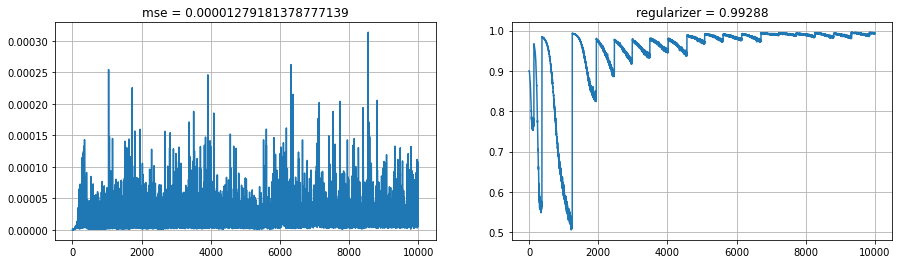

GraphEmbedding(178 vertices, 714 edges total, 710 edges kept, 0.0056022 sparsity rate)



In [6]:
stage, emb, opt = lib.update_learning_rate(stage, len(loss_history), emb, prune_threshold=prune_threshold)
print("Stage:", stage)
for i in tqdm(range(len(loss_history), 10000)):
    source = torch.randint(0, len(X), [batch_size])
    target = torch.randint(0, len(X), [batch_size])

    pred = emb(source, target)
    distances_ref = torch.as_tensor(distances[source, target], dtype=torch.float32)
    
    reconstruction_mse = F.mse_loss(pred['target_distances'], distances_ref)
    regularizer = emb.compute_l0_prior_penalty(4096)
    lambd = min(1, len(loss_history) / 10000.) * (emb.num_edges / total_edges) * 10.0
    # Equation 2 + log deriative trick
    loss = reconstruction_mse - pred['logp_target_paths'].mean() + lambd * regularizer
    opt.zero_grad()
    loss.backward()
    opt.step()
    loss_history.append(reconstruction_mse.item())
    reg_history.append(regularizer.item())
    
    # early stopping       
    edges_kept = np.sum(lib.check_numpy(emb.edge_adjacency_logits >= 0).astype('int64'))
    if edges_kept <= num_edges_req:
        print('Early stopping at epoch:', i)
        break

    # dynamic updating of LR/pruning  
    if len(reg_history) > 100 and i > last_updated:
        limit = round(reg_history[-30], 3)
        if stage <= 3:
            if all(round(i, 3) >= limit for i in reg_history[-30:]):
                stage, emb, opt = lib.update_learning_rate(stage, len(loss_history), emb, prune_threshold=prune_threshold)
                last_updated = i + 50
        else:
            if all(round(i, 3) >= limit for i in reg_history[-30:]):
                stage, emb, opt = lib.update_learning_rate(stage, len(loss_history), emb, 
                                                           prune_threshold=prune_threshold, decrease_lr=False)
                last_updated = i + 500

    if len(loss_history) % 100 == 0:
        clear_output(True)
        print("Stage:", stage)
        plt.figure(figsize=[15, 4])
        plt.subplot(1, 2, 1);
        plt.title('mse = %.20f' % loss_history[-1]); plt.grid()
        plt.plot(loss_history)
        plt.subplot(1, 2, 2);
        plt.title('regularizer = %0.5f' % reg_history[-1]); plt.grid()
        plt.plot(reg_history)
        plt.show()
        print(emb)

In [8]:
dist_prodige = emb.compute_pairwise_distances()
emb.report_model_size()

{'size_bytes': 6392.0,
 'num_vertices': 180,
 'num_edges': 709,
 'threshold': 0.5,
 'self': GraphEmbedding(178 vertices, 714 edges total, 710 edges kept, 0.0056022 sparsity rate)}

In [9]:
print("PCA:\t %.20f" % np.mean(np.square(distances - dist_pca)))
print("MDS:\t %.20f" % np.mean(np.square(distances - dist_mds)))
print("PRODIGE: %.20f" % np.mean(np.square(distances - dist_prodige)))

PCA:	 0.00000016524072667859
MDS:	 0.00000571916569096827
PRODIGE: 0.00000394928667661297


#### Generate PRODIGE as a NetworkX file

In [ ]:
G = lib.generate_networkx_graph(emb, y)

In [ ]:
import pickle
with open('./wine_prodige_binary2.bin', 'wb') as _file:
    pickle.dump(G, _file)

In [ ]:
output_file(f'{dataset}_graph.html')
p = lib.draw_networkx_graph(G, dataset, weighted=True)
save(p, f'{dataset}_graph.html')

```

```

```

```

```

```

```

```

```

```
